<a href="https://colab.research.google.com/github/ulya1202/Computer_vision_projects/blob/main/TMINST_with_low_level_api_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TMNIST

##Import

In [ ]:
from tqdm.auto import tqdm

In [ ]:
import pandas as pd
import torch.nn
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
from accelerate import Accelerator

In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
import torcheval
import torcheval.metrics

In [ ]:
import torch.nn

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

!curl -L -o tmnist-typeface-mnist.zip  https://www.kaggle.com/api/v1/datasets/download/nimishmagre/tmnist-typeface-mnist

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8261k  100 8261k    0     0  8095k      0  0:00:01  0:00:01 --:--:-- 34.9M


In [ ]:
!unzip /content/tmnist-typeface-mnist.zip

Archive:  /content/tmnist-typeface-mnist.zip
  inflating: TMNIST_Data.csv         


## Functions

In [ ]:
def split_data(df,test_size=0.15, val_size=0.15):
    l=len(df)
    total_eval_size=test_size+val_size
    train_size=1-total_eval_size
    df.sample(frac=1).reset_index(drop=True)
    last_i=int(l*train_size)
    train_df=df[:last_i]
    val_df=None
    test_df=None
    if total_eval_size==0:
        return train_df
    if val_size:
        val_df=df[last_i:last_i+int(l*val_size)]
    if test_size:
        if val_size: last_i=last_i+int(l*val_size)
        test_df=df[last_i:last_i+int(l*test_size)]

    return  train_df, val_df, test_df




## Classes

### DataSet classe

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file,transform_img=None, custom_transform=None):
        super().__init__()
        self.data=file
        self.imgs=self.data.iloc[:,2:].to_numpy()
        self.labels=self.data.iloc[:,1].to_numpy()
        self.transform_img=transform_img
        self.custom_transform=custom_transform

        self.features=self.imgs.shape[-1]
        self.img_width=int(self.features**0.5)



    def __len__(self):
        return len(self.labels)

    def _transform(self,img):
        if img.ndim==1:
            img=img.reshape(self.img_width,self.img_width)
        img = img.astype(np.float32) / 255.0

        return img
    def plot(self, index_list=None, cmap='gray', h=None, w=None, axis='off'):
        if h==None or w==None:
            h=int(np.ceil(len(index_list)**0.5))
            w=len(index_list)//h
        for i,idx in enumerate(index_list):
            img=self.reshape_me(self.imgs[idx])
            plt.subplot(h,w,i+1)
            plt.imshow(img, cmap=cmap)
            plt.title(f'label:{self.labels[idx]}')
            plt.axis(axis)


    def reshape_me(self, img):
        if img.ndim==1 :
            img=img.reshape(self.img_width,self.img_width)
        return img



    def __getitem__(self, idx):
        if self.transform_img:
            img=self._transform(self.imgs[idx])
        elif self.custom_transform:
            img=self.custom_transform(self.imgs[idx])
        else:
            img=self.imgs[idx]

        t_img=torch.tensor(np.atleast_3d(self.reshape_me(img)),dtype=torch.float32)
        if img.ndim<=2:
            t_img=t_img.permute(2,1,0)


        label=torch.tensor(self.labels[idx], dtype=torch.long)

        return t_img, label

### Model Classes

In [ ]:
#extra information about nn.Conv2d:
# | Parametr       | İzah                                                       | #GROUPS!!--> bu qruplashdirir cannel uzre , 1 olarsa demeli butun shekile 1 qrup kimi baxir ve 1 filtr tetbiq edir
# | -------------- | ---------------------------------------------------------- |                      |___>eger 2 olarsa channaleri 2 qrupa bolur, ve tutalim 1 ci ve 2 ci ni bir filtr, 3 ve 4 cunu bashqa filtrden kecirir
# | `in_channels`  | Girişdəki kanal sayı (məs: RGB → 3)                        |                       |____>bele cixir ki eger men butun daxil olan chanallerin sayina berebr etsem qruplashdirami , o bher chanellea ari filtr tetebiq eder, bu ise deptwise sayilir
# | `out_channels` | İstədiyin çıxış kanal sayı (məs: 16 filtr)                 | ###  adi
# | `kernel_size`  | Hər filtrin ölçüsü: 3, 5 və s. (kvadrat və ya `(h, w)`)    |  Input Channel 1 ─┐           ┌─> Output Channel 1    ## Depthwise-->nn.Conv2d(in_channels=C, out_channels=C, kernel_size=3, groups=C)
# | `stride`       | Filtrin neçə-neçə addımla getməsidir. (default: 1)         |  Input Channel 2 ─┼─> Filter ─┤                           ##PointWise-->nn.Conv2d(in_channels=C, out_channels=C*K, kernel_size=1)
# | `padding`      | Şəklin kənarına sıfır əlavə olunması. “same” ölçü saxlayar |  Input Channel 3 ─┘           └─> Output Channel 2
# | `dilation`     | Filtr elementləri arasına boşluq qoyar                     | ####deptwise group=in_channel
# | `groups`       | 1: normal conv. `groups=Cin` → depthwise convolution       |   Input Channel 1 ─> Filter 1 ─> Output Channel 1
# | `bias`         | Hər filtrin əlavə sabit bias dəyəri                        |   Input Channel 2 ─> Filter 2 ─> Output Channel 2
#                                                                                   Input Channel 3 ─> Filter 3 ─> Output Channel 3
#PyTorch istifadə edirsənsə: şəkli [C, H, W] formatına gətir.(C-channale)
#TensorFlow istifadə edirsənsə: şəkil [H, W, C] formatında olmalıdır.


In [ ]:
import torch

class MySimplestModel(torch.nn.Module):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.chan=input_shape[-3]
        self.batch_norm=torch.nn.BatchNorm2d(self.chan)
        self.conv_1=torch.nn.Conv2d(self.chan, 128, kernel_size=7, padding='same')
        self.conv_2=torch.nn.Conv2d(self.conv_1.out_channels, 256, kernel_size=7, padding='same')
        self.flat=torch.nn.AdaptiveMaxPool2d((1, 1))
        self.dense=torch.nn.Linear(256 , num_classes)

    def forward(self,input):
        x=self.batch_norm(input)
        x=self.conv_1(x)
        x=torch.nn.functional.relu(x)
        x=self.conv_2(x)
        x=torch.nn.functional.relu(x)
        x=self.flat(x).squeeze(-1).squeeze(-1)
        x=self.dense(x)
        return x

In [ ]:


class MyMiddleModel(torch.nn.Module):
    def __init__(self, input_shape, num_classes,first_out_channel=128):
        super().__init__()
        self.channels=input_shape[0]#bax nece bottleneck elemek oalr ve.s
        self.h=input_shape[1]
        self.w=input_shape[2]
        self.num_class=num_classes

        self.conv1=torch.nn.Conv2d(in_channels=self.channels, out_channels=first_out_channel,kernel_size=7, padding='same')
        self.conv2=torch.nn.Conv2d(in_channels=self.conv1.out_channels, out_channels=self.conv1.out_channels*2,kernel_size=5, groups=self.conv1.out_channels, padding='same')
        self.conv3=torch.nn.Conv2d(in_channels=self.conv2.out_channels, out_channels=self.conv2.out_channels, kernel_size=1, padding='same')


        self.max_pool=torch.nn.MaxPool2d(kernel_size=self.w)

        self.conv_output=torch.nn.Conv2d(in_channels=self.conv3.out_channels + self.conv1.out_channels, out_channels=self.num_class, kernel_size=1)
        self.bn0=torch.nn.BatchNorm2d(self.channels)
        self.bn1=torch.nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2=torch.nn.BatchNorm2d(self.conv2.out_channels)
        self.bn3=torch.nn.BatchNorm2d(self.conv3.out_channels)


    def forward(self, input):
        input=self.bn0(input)
        x=self.conv1(input)
        x=self.bn1(x)
        skip1=torch.nn.functional.relu(x)


        x=self.conv2(skip1)
        x=self.bn2(x)
        x=torch.nn.functional.relu(x)


        x=self.conv3(x)
        x=self.bn3(x)
        x=torch.nn.functional.relu(x)

        x=torch.cat((x,skip1),1)

        x=self.max_pool(x)
        x=self.conv_output(x)
        out=torch.nn.Flatten()(x)
        return out

In [ ]:
# class MyResNet(torch.nn.Module):
#     def __init__(self,list_repeating, num_class, preprocess=None):
#         super().__init__()
#         self.list_repeating=list_repeating
#         self.num_class=num_class
#         self.preprocess=preprocess

#     def conv_x(self,input,input_size,output_size, stride=1):
#         x=torch.nn.Conv2d(input_size, output_size, kernel_size=3, stride=stride)(input)
#         x=torch.nn.BatchNorm2d(output_size)(x)
#         x=torch.nn.functions.relu(x)
#         return x

#     def conv_b(self, input, conv_block_num, stride=1):
#         x=self.conv_x(input,conv_block_num,conv_block_num)(input)
#         x=self.conv_x(input,conv_block_num,conv_block_num)(input)
#         x=torch.cat((x,input), dim=-3)
#         return x, input
#     def block(self,x):
#         l=[]
#         for i, num in enumerate(self.list_repeating):
#             for i in range(num):
#                 l.append(64*(i+1))
#             x,skip=self.conv_b(x,l[i])
#             if l[i]!=l[i+1]:
#                 skip=torch.nn.Conv2d(l[i],l[i+1],stride=2, kernel_size=1)(skip)
#             x=torch.cat((x,skip),dim=-3)
#             if i+2==len(l):
#                 x,skip=self.conv_x(x,l[i],l[i])
#         return x, l[-1]

#     def forward(self,input):
#         input_ch=input.size()[-1]
#         if self.preprocess:
#             x=torchvision.transforms.Resize((-1,224,224))(x)
#         x=self.conv_x(input,input_ch,64)
#         x=torch.nn.MaxPool2d(kernel_size=3, stride=2)(x)
#         x=torch.cat((x,input), dim=-3)
#         x,out_f=self.block(x)
#         x=torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
#         x=torch.nnLinear(in_features=out_f, out_features=self.num_class, bias=True)
#         return x







### Trainer class

In [ ]:
class Train:
    def __init__(self, model, num_training_epochs, train_loader=None, test_loader=None, val_loader=None,
                 optimizer=None, loss=None, lr_scheduler=None, accel=True, num_classes=None, metrics='classification'):
        self.num_training_epochs = num_training_epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.loss = loss
        self.lr_scheduler = lr_scheduler
        self.accel = accel
        self.model = model
        self.accelerate = Accelerator()
        self.dic = {'train_loss': [], 'val_loss': [], 'train_loss_each_batch':[],  'val_loss_each_batch':[]}
        self.progress_bar=None

        self.num_steps_each_epoch = len(train_loader)
        self.total_stepsize = self.num_steps_each_epoch * num_training_epochs
        # self.progress_bar = tqdm(range(self.total_stepsize))

        if accel:
            self.model, self.train_loader, self.val_loader, self.test_loader, self.optimizer, self.lr_scheduler ,self.dic= \
                self.accelerate.prepare(model, train_loader, val_loader, test_loader, optimizer, lr_scheduler,self.dic)

        if metrics == 'classification' and num_classes is not None:
            self.met_name = ['f1', 'recall', 'precision', 'acc']
            self.dic_metrics_train = {
                'f1': torcheval.metrics.MulticlassF1Score(num_classes=num_classes),
                'recall': torcheval.metrics.MulticlassRecall(num_classes=num_classes),
                'precision': torcheval.metrics.MulticlassPrecision(num_classes=num_classes),
                'acc': torcheval.metrics.MulticlassAccuracy(num_classes=num_classes)
            }
            self.dic_metrics_val = {
                k: v.__class__(num_classes=num_classes) for k, v in self.dic_metrics_train.items()
            }
            if accel:
                for k in self.dic_metrics_train:
                    self.dic_metrics_train[k] = self.accelerate.prepare(self.dic_metrics_train[k])
                    self.dic_metrics_val[k] = self.accelerate.prepare(self.dic_metrics_val[k])
    def train_iter(self,external_data=None ):
        self.train_loader=external_data if external_data  else self.train_loader
        if not self.progress_bar:
            self.progress_bar=tqdm(range(len(self.train_loader)))
        self.model.train()
        for i, batch in enumerate(self.train_loader):
                  # print(f'batch_train {i+1}/{len(train_loader)}')
                  img, label=batch
                  output=self.model(img)
                  losses=self.loss(output,label)
                  self.accelerate.backward(losses)
                  self.optimizer.step()
                  self.optimizer.zero_grad()
                  predicted=output.argmax(-1)
                  self.progress_bar.update(1)
                  if self.accel:
                      predicted=self.accelerate.gather(predicted)
                      label=self.accelerate.gather(label)
                  yield  img, label, output, predicted, losses

    def evaluation_loop(self, iterator_fn, metric_dic):

        if not self.progress_bar:
            self.progress_bar=tqdm(range(len(self.train_loader)))
        losses = []
        for img, label, output, predicted, loss in iterator_fn():
            for metric in self.met_name:
                metric_dic[metric].update(predicted, label)
            losses.append(loss.item())
        return losses

    def eval_iter(self,external_data =None):
        self.val_loader=external_data if external_data  else self.val_loader
        if not self.progress_bar:
            self.progress_bar=tqdm(range(len(self.train_loader)))
        self.model.eval()
        for batch in self.val_loader:
                  img, label=batch

                  with torch.no_grad():
                      output=self.model(img)
                  losses=self.loss(output,label)
                  predicted=output.argmax(-1)
                  losses=self.loss(output,label)

                  if self.accel:
                      predicted=self.accelerate.gather(predicted)
                      label=self.accelerate.gather(label)
                  yield img, label, output, predicted, losses



    def train_eval(self):
        self.progress_bar = tqdm(range(self.total_stepsize))
        for epoch in range(self.num_training_epochs):
            train_loss=self.evaluation_loop(self.train_iter,self.dic_metrics_train)
            print('train ', end='=>>')
            print(({k: v.compute().item() for k, v in self.dic_metrics_train.items()}), end='---')
            self.dic['train_loss'].append(sum(train_loss)/len(train_loss))
            self.dic['train_loss_each_batch'].extend(train_loss)
            for metric in self.dic_metrics_train.values(): metric.reset()
            if self.val_loader:
                val_loss=self.evaluation_loop(self.eval_iter,self.dic_metrics_val)
                print(' val ', end='=>>')
                print(({k: v.compute().item() for k, v in self.dic_metrics_val.items()}))
                self.dic['val_loss'].append(sum(val_loss)/len(val_loss))
                self.dic['val_loss_each_batch'].extend(val_loss)
                for metric in self.dic_metrics_val.values(): metric.reset()
            print('\n')
        return  self.dic

    def test_eval(self, external_data=None):
        loader= external_data if external_data else self.test_loader
        if not loader:
            print('Test datasi elave edin !!')
        return None, None
        test_metrics = self.dic_metrics_val = {
                k: v.__class__(num_classes=num_classes) for k, v in self.dic_metrics_train.items()
            }
        if self.accel:
            for k in test_metrics:
                test_metrics[k] = self.accelerate.prepare(test_metrics[k])
        losses, metrics_result = self.evaluation_loop(self.eval_iter(loader), test_metrics)
        for metric in self.test_metrics.values(): metric.reset()
        print("Test =>", metrics_result)
        return losses, metrics_result

## EDA and Splitting Data

In [ ]:
df=pd.read_csv('TMNIST_Data.csv')

In [ ]:
train_df, val_df, test_df=split_data(df)
train_dataset=CustomDataset(train_df, transform_img=True)
val_dataset=CustomDataset(val_df, transform_img=True)
test_dataset=CustomDataset(test_df, transform_img=True)


In [ ]:
batch_size=32
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size)
val_loader=DataLoader(val_dataset, batch_size=batch_size)

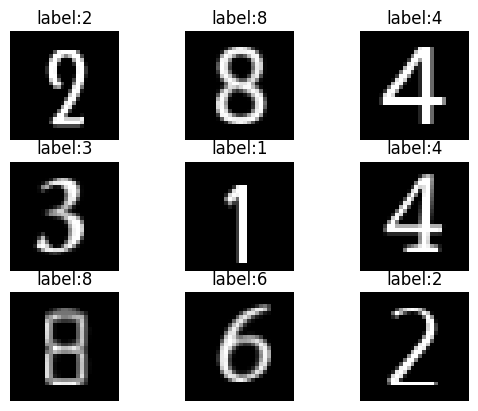

In [ ]:
train_dataset.plot(index_list=[i for i in range(9)])

## Model optimizers learning rate and.etc

### Optimizer and other like Learning rate schedular

In [ ]:
model=MySimplestModel([1,28,28],num_classes=10)

In [ ]:
num_training_epochs=10
optimizer=torch.optim.NAdam(model.parameters(), lr=0.0001)
loss=torch.nn.CrossEntropyLoss()
num_steps_each_epoch=len(train_loader)
total_stepsize=num_training_epochs*num_steps_each_epoch

lr_scehdular=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.01,total_steps=total_stepsize,steps_per_epoch=num_steps_each_epoch)

trainer=Train(model,num_training_epochs,train_loader,test_loader ,val_loader,optimizer,loss, lr_scehdular,num_classes=10)

In [ ]:
hist=trainer.train_eval()

  0%|          | 0/655 [00:00<?, ?it/s]

train =>>{'f1': 0.998948872089386, 'recall': 0.998948872089386, 'precision': 0.998948872089386, 'acc': 0.998948872089386}--- val =>>{'f1': 0.9948717951774597, 'recall': 0.9948717951774597, 'precision': 0.9948717951774597, 'acc': 0.9948717951774597}




In [ ]:
train_losses=hist['train_loss']
val_losses=hist['val_loss']
plt.plot([i for i in range(len(train_losses))],train_losses)
plt.plot([i for i in range(len(val_losses))],val_losses, c='g')



plt.show()